# Final Analysis Results

In [2]:
import glob
import ipdb
import pickle as pkl
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
ls ../../results_inference

detfull_encoder_task_graph/  VAE.KL.0.0/  VAE.KL.0.001/  VAE.KL.1.0/


In [3]:
import pickle as pkl
with open('../../results_inference/VAE.KL.0.001/logs_episode.108_iter.0.pik_result.pkl', 'rb') as f:
    cont = pkl.load(f)

In [4]:
cont['length'].shape

()

In [5]:
cont.keys()

dict_keys(['results_total', 'results_total_tstep', 'gt_task', 'pred_task', 'length'])

In [6]:
cont['length']

array(31., dtype=float32)

In [7]:
compute_metrics(cont['pred_task'], cont['gt_task'], cont['length'])

NameError: name 'compute_metrics' is not defined

In [ ]:
def get_files(file_path, use_posterior=False):
    if use_posterior:
        files = [file for file in glob.glob('{}/*.pkl'.format(file_path)) if 'posterior' in file]
    else:
        files = [file for file in glob.glob('{}/*.pkl'.format(file_path)) if 'posterior' not in file]
    return files

In [ ]:
def bin_data(content, nbins=10, debug=False):
    # put data in nbins according to episode length
    res = content['results_total_tstep']['accuracy_pos_seed']
    nseeds = res.shape[0]
    length = content['length']
    bin_data = np.zeros((nbins, nseeds))
    
    tsteps_per_bin = length/nbins
    
    for i in range(nbins):
        ind1 = round(i * tsteps_per_bin)
        ind2 = round((i+1)*tsteps_per_bin)
        bin_data[i] = res[:, ind1:ind2, ...].mean(1)
    bin_data_mean = bin_data.mean(-1)
    bin_data_max = bin_data.max(-1)
    bin_data_std = bin_data.std(-1) / np.sqrt(11)
    return bin_data_mean, bin_data_std, bin_data_max

In [8]:
def get_info_episodes(exp_name):
    print(f"Loading {exp_name}")
    file_path = f'../../results_inference/{exp_name}'
    files_interest = get_files(file_path)
    all_mean, all_se, all_max = [], [], []
    for cfile_name in files_interest:
        with open(cfile_name, 'rb') as f:
            cont = pkl.load(f)
        b_mean, b_se, b_max = bin_data(cont)
        
        all_mean.append(b_mean[None, :])
        all_se.append(b_se[None, :])
        all_max.append(b_max[None, :])
    all_mean = np.concatenate(all_mean, 0)
    all_max = np.concatenate(all_max, 0)
    all_se = np.concatenate(all_se, 0)
    return all_mean, all_se, all_max

In [ ]:
names = [x.split('/')[-1] for x in glob.glob('../../results_inference/*')]
print(names)
plt.figure()
ax = plt.gca()
for name_exp in names:
#     color=next(ax._get_lines.color_cycle)
    color=next(ax._get_lines.prop_cycler)['color']
    print(color)
    all_mean, all_se, all_max = get_info_episodes(name_exp)
    x = np.arange(10)
    mean_return = all_mean.mean(0)
    mean_se = all_se.mean(0)
    ymin = mean_return - mean_se
    ymax = mean_return + mean_se
    plt.plot(x, mean_return, label=name_exp, color=color)
    plt.plot(x, all_max.mean(0), '--', color=color)
    plt.fill_between(x, ymin, ymax, alpha=0.2, color=color)

plt.ylabel("Accuracy of changing preds")
plt.xlabel("Time step")
plt.grid()
plt.legend()

In [ ]:
all_mean.shape

# Recall

In [8]:
def get_files(file_path, use_posterior=False):
    if use_posterior:
        files = [file for file in glob.glob('{}/*.pkl'.format(file_path)) if 'posterior' in file]
    else:
        files = [file for file in glob.glob('{}/*.pkl'.format(file_path)) if 'posterior' not in file]
    return files

In [9]:
import ipdb
eps = 1e-9
def compute_tsteps(metric, len_mask, nbins=10):
    
    # Put metrics in timesteps
    nseeds = metric.shape[0]
    length = len_mask.sum(-1)
    norm_mask = len_mask / len_mask.sum(-1)[..., None]
    tsteps_per_bin = length/nbins
    bin_data = np.zeros((nbins, nseeds))
    
    mean = (metric * norm_mask).sum(-1)
    for i in range(nbins):
        ind1 = round(i * tsteps_per_bin)
        ind2 = round((i+1)*tsteps_per_bin)
        bin_data[i] = metric[:, ind1:ind2, ...].mean(1)
    return mean, bin_data

def compute_metrics(pred_task, gt_task, length, nbins=10, debug=False):
    gt_task = gt_task[None, ...]
    length = int(length)
    T = pred_task.shape[1]
    gt_task_d = gt_task[None, ...]
    len_mask = np.zeros(T)
    len_mask[:length] = 1
    
    gt_p = gt_task / gt_task.sum(-1)[..., None]
    pos_gt_p = (gt_task > 0) / ((gt_task > 0).sum(-1)[..., None] + eps)
    pred_p = (pred_task > 0) / ((pred_task > 0).sum(-1)[..., None] + eps)
    
    accuracy = (((gt_task == pred_task) * pos_gt_p).sum(-1)).mean(0)[None, ...]
    recall = (np.minimum(pred_task, gt_task).sum(-1) / (eps+gt_task.sum(-1))).mean(0)[None, ...]
    prec = (np.minimum(pred_task, gt_task).sum(-1) / (eps+pred_task.sum(-1))).mean(0)[None, ...]
    
    accuracymax = (((gt_task == pred_task) * pos_gt_p).sum(-1)).max(0)[None, ...]
    recallmax = (np.minimum(pred_task, gt_task).sum(-1) / (eps+gt_task.sum(-1))).max(0)[None, ...]
    precmax = (np.minimum(pred_task, gt_task).sum(-1) / (eps+pred_task.sum(-1))).max(0)[None, ...]
    
    
    max_gt_pred = gt_task.max(-1)
#     ipdb.set_trace()
    std = np.std(pred_task, axis=0).mean(-1)[None, ...]
    
#     ipdb.set_trace()
    m_ac, t_ac = compute_tsteps(accuracy, len_mask, nbins)
    m_rec, t_rec = compute_tsteps(recall, len_mask, nbins)
    m_prec, t_prec = compute_tsteps(prec, len_mask, nbins)
    m_std, t_std = compute_tsteps(std, len_mask, nbins)
    
    m_acm, t_acm = compute_tsteps(accuracymax, len_mask, nbins)
    m_recm, t_recm = compute_tsteps(recallmax, len_mask, nbins)
    m_precm, t_precm = compute_tsteps(precmax, len_mask, nbins)
    if debug:
        ipdb.set_trace()
    dict_res = {
        'gt_task': gt_task,
        'mean_accuracy': m_ac,
        'mean_recall': m_rec,
        'mean_precision': m_prec,
        'mean_std': m_std,
        'recall_tsteps': t_rec,
        'accuracy_tsteps': t_ac,
        'precision_tsteps': t_prec,
        'std_tsteps': t_std,
        'recallmax_tsteps': t_recm,
        'accuracymax_tsteps': t_acm,
        'precisionmax_tsteps': t_precm,
        'std_tsteps': t_std
    }
    return dict_res

def get_random(size):
    # returns a tensor of size [size, 136] with random samples
    max_vec = ("0 0 0 2 0 5 0 3 0 0 2 0 0 0 1 0 0 0 0 0 "
               "0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 "
               "0 0 0 0 0 0 0 2 0 7 0 2 0 0 2 0 0 0 3 7 "
               "0 0 3 0 0 0 0 0 0 3 7 0 0 3 0 0 0 0 0 0 "
               "2 0 6 0 3 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 "
               "0 0 2 0 7 0 3 0 0 2 0 0 0 2 6 0 0 3 0 0 "
               "0 0 0 0 3 6 0 0 3 0 0 0 0 0 1 1")
    max_vec = np.array([int(x) for x in max_vec.split()])
    new_size = list(size)+[max_vec.shape[0]]
    res = np.random.rand(*new_size)
    
    res *= max_vec
    res = res.astype(np.int32)
    return res

def get_info_episodes_new(exp_name, rand_uniform=False):
    print(f"Loading {exp_name}")
    file_path = f'../../results_inference/{exp_name}'
    files_interest = get_files(file_path)
    all_results = {}
    for cfile_name in files_interest:
        with open(cfile_name, 'rb') as f:
            cont = pkl.load(f)
        if type(cont) == list:
            continue
        if not rand_uniform:
            results = compute_metrics(cont['pred_task'], cont['gt_task'], cont['length'])
        else:
            random_vec = get_random(cont['pred_task'].shape[:-1])
            results = compute_metrics(random_vec, cont['gt_task'], cont['length'], debug=False)
            
        for name_res, res_val in results.items():
            if name_res not in all_results:
                all_results[name_res] = [res_val[None, ...]]
            else:
                all_results[name_res].append(res_val[None, ...])
    aggregated_results = {}
    aggregated_results['names'] = list(all_results.keys())
    for res_name, res_val in all_results.items():
        res_val = np.concatenate(res_val, 0)
        if res_name == 'gt_task':
            continue
        all_results_mean = res_val.mean(0)
        all_results_std = res_val.std(0) / np.sqrt(res_val.shape[0])

        aggregated_results[f'{res_name}_mean'] = all_results_mean.mean(-1)
        aggregated_results[f'{res_name}_std'] = all_results_std .mean(-1)
    return aggregated_results

In [10]:
original_name_exp = '../../results_inference/detfull_encoder_task_graph/logs_episode.534_iter.0.pik_result.pkl'

with open(original_name_exp, 'rb') as f:
    cont = pkl.load(f)
results = compute_metrics(cont['pred_task'], cont['gt_task'], cont['length'])
results['accuracy_tsteps'][0]

array([0.15909091])

In [11]:
original_name_exp = '../../results_inference/VAE.KL.0.001/logs_episode.534_iter.0.pik_result.pkl'

with open(original_name_exp, 'rb') as f:
    cont = pkl.load(f)
results = compute_metrics(cont['pred_task'], cont['gt_task'], cont['length'])
results['accuracy_tsteps'][0]

array([0.23863636])

In [12]:
results['accuracy_tsteps'][0]

array([0.23863636])

Loading VAE.KL.0.001
Loading detfull_encoder_task_graph
Loading VAE.KL.1.0
Loading VAE.KL.0.0
Loading VAE.KL.0.0


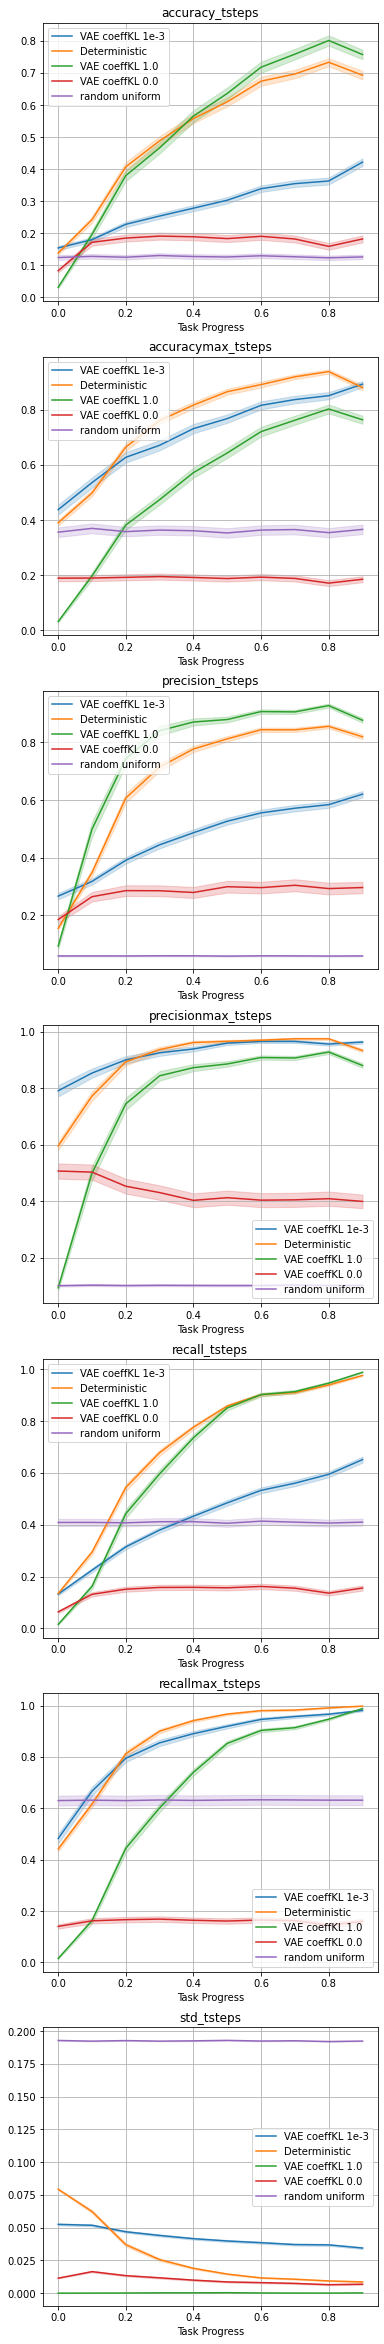

In [13]:
names_exp = [x.split('/')[-1] for x in glob.glob('../../results_inference/*')]
names_exp.append(names_exp[-1])
# print(names)
ax_plots = None

ax = plt.gca()
colors=[next(ax._get_lines.prop_cycler)['color'] for _ in range(len(names_exp))]
plt.close()
name_dict = {
    'VAE.KL.0.0': 'VAE coeffKL 0.0',
    'VAE.KL.1.0': 'VAE coeffKL 1.0',
    'VAE.KL.0.001': 'VAE coeffKL 1e-3',
    'detfull_encoder_task_graph': 'Deterministic',
    'random uniform': 'random uniform'
}
for index_exp, name_exp in enumerate(names_exp):
    original_name_exp = name_exp
    if index_exp == (len(names_exp) - 1):
        name_exp = 'random uniform'
        rand = True
    else:
        rand = False
    color = colors[index_exp]
#     name_exp = 
    final_res = get_info_episodes_new(original_name_exp, rand)
    if ax_plots is None:
        names = sorted([name for name in final_res['names'] if 'steps' in name])
        fig, ax_plots = plt.subplots(len(names), 1, figsize=(6, 6*len(names)))

#     if rand:
#         ipdb.set_trace()
    for index, name_metric in enumerate(names):
#         color=colors[index_exp]
        curr_ax = ax_plots[index]
        x = np.arange(10)*1/10
#         print(name_metric, x.shape, mean_return.shape)
        mean_return = final_res[name_metric+'_mean']
        mean_se = final_res[name_metric+'_std']
#         mean_se = all_se.mean(0)
        ymin = mean_return - mean_se
        ymax = mean_return + mean_se
        curr_ax.plot(x, mean_return, label=name_dict[name_exp], color=color)
#         curr_ax.plot(x, all_max.mean(0), '--', color=color)
        curr_ax.fill_between(x, ymin, ymax, alpha=0.2, color=color)
for ind, ax in enumerate(ax_plots):
    ax.legend()
    ax.set_title(names[ind])
    ax.grid()
    ax.set_xlabel("Task Progress")

# Debug

In [11]:
# Check differences in recall

In [8]:
names_exp = [x.split('/')[-1] for x in glob.glob('../../results_inference/*')]
deterministic = names_exp[1]
# final_res = get_info_episodes_new(deterministic, rand)

In [44]:
names_exp

['VAE.KL.0.001', 'detfull_encoder_task_graph', 'VAE.KL.1.0', 'VAE.KL.0.0']

In [ ]:
eps = 1e-9
def get_files(file_path, use_posterior=False):
    if use_posterior:
        files = [file for file in glob.glob('{}/*.pkl'.format(file_path)) if 'posterior' in file]
    else:
        files = [file for file in glob.glob('{}/*.pkl'.format(file_path)) if 'posterior' not in file]
    return files

def compute_tsteps(metric, len_mask, nbins=10, debug=False):
    
    # Put metrics in timesteps
    nseeds = metric.shape[0]
    length = len_mask.sum(-1)
    norm_mask = len_mask / len_mask.sum(-1)[..., None]
    tsteps_per_bin = length/nbins
    bin_data = np.zeros((nbins, nseeds))
    
    mean = (metric * norm_mask).sum(-1)
    for i in range(nbins):
        ind1 = round(i * tsteps_per_bin)
        ind2 = round((i+1)*tsteps_per_bin)
        if debug:
            print(ind1, ind2, metric[:, ind1:ind2, ...].mean(1))
        bin_data[i] = metric[:, ind1:ind2, ...].mean(1)
#     ipdb.set_trace()
    return mean, bin_data

def compute_metrics(pred_task, gt_task, length, nbins=10, debug=False):
    gt_task = gt_task[None, ...]
    length = int(length)
    T = pred_task.shape[1]
    gt_task_d = gt_task[None, ...]
    len_mask = np.zeros(T)
    len_mask[:length] = 1
    
    gt_p = gt_task / gt_task.sum(-1)[..., None]
    pos_gt_p = (gt_task > 0) / ((gt_task > 0).sum(-1)[..., None] + eps)
    pred_p = (pred_task > 0) / ((pred_task > 0).sum(-1)[..., None] + eps)
    
    accuracy = (((gt_task == pred_task) * pos_gt_p).sum(-1)).mean(0)[None, ...]
    recall = (np.minimum(pred_task, gt_task).sum(-1) / (eps+gt_task.sum(-1))).mean(0)[None, ...]
    prec = (np.minimum(pred_task, gt_task).sum(-1) / (eps+pred_task.sum(-1))).mean(0)[None, ...]
    
    accuracymax = (((gt_task == pred_task) * pos_gt_p).sum(-1)).max(0)[None, ...]
    recallmax = (np.minimum(pred_task, gt_task).sum(-1) / (eps+gt_task.sum(-1))).max(0)[None, ...]
    precmax = (np.minimum(pred_task, gt_task).sum(-1) / (eps+pred_task.sum(-1))).max(0)[None, ...]
    
    
    max_gt_pred = gt_task.max(-1)
#     ipdb.set_trace()
    std = np.std(pred_task, axis=0).mean(-1)[None, ...]
    
#     ipdb.set_trace()
#     print(recallmax[0])
#     print(recallmax)
    m_ac, t_ac = compute_tsteps(accuracy, len_mask, nbins)
    m_rec, t_rec = compute_tsteps(recall, len_mask, nbins)
    m_prec, t_prec = compute_tsteps(prec, len_mask, nbins)
    m_std, t_std = compute_tsteps(std, len_mask, nbins)
    
    m_acm, t_acm = compute_tsteps(accuracymax, len_mask, nbins)
    m_recm, t_recm = compute_tsteps(recallmax, len_mask, nbins)
    m_precm, t_precm = compute_tsteps(precmax, len_mask, nbins)
    if debug:
        ipdb.set_trace()
    dict_res = {
        'gt_task': gt_task,
        'mean_accuracy': m_ac,
        'mean_recall': m_rec,
        'mean_precision': m_prec,
        'mean_std': m_std,
        'recall_tsteps': t_rec,
        'accuracy_tsteps': t_ac,
        'precision_tsteps': t_prec,
        'std_tsteps': t_std,
        'recallmax_tsteps': t_recm,
        'accuracymax_tsteps': t_acm,
        'precisionmax_tsteps': t_precm,
        'std_tsteps': t_std
    }
    return dict_res, recallmax

exp_name = deterministic
print(f"Loading {exp_name}")
file_path = f'../../results_inference/{exp_name}'
files_interest = get_files(file_path)
all_results = {}
i = 0
for cfile_name in sorted(files_interest):
#     if '534' not in cfile_name:
#         continue
#     if i == 0:
#         i += 1
#         continue
   
    with open(cfile_name, 'rb') as f:
        cont = pkl.load(f)
    if type(cont) == list:
        continue
    results, rm = compute_metrics(cont['pred_task'], cont['gt_task'], cont['length'])
    
    with open(cfile_name.replace(names_exp[1], names_exp[0]), 'rb') as f:
        cont2 = pkl.load(f)
    if type(cont2) == list:
        continue
    results2, rm2 = compute_metrics(cont2['pred_task'], cont2['gt_task'], cont2['length'])
    
    m1 = results['recallmax_tsteps'].mean()
    m2 = results2['recallmax_tsteps'].mean()
    if m1 > m2:
        print(results['recallmax_tsteps'])
        print(results2['recallmax_tsteps'])
        print(cfile_name)
        ipdb.set_trace()

Loading detfull_encoder_task_graph
[[0.61904762]
 [0.80952381]
 [0.9047619 ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]]
[[0.71428571]
 [0.71428571]
 [0.80952381]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.95238095]
 [1.        ]]
../../results_inference/detfull_encoder_task_graph/logs_episode.108_iter.0.pik_result.pkl
> /tmp/ipykernel_16805/4060551077.py(89)<module>()
     88 i = 0
---> 89 for cfile_name in sorted(files_interest):
     90 #     if '534' not in cfile_name:

